# Part 2 - Tiny Model training using nanoGPT

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!mkdir -p /content/dataset

In [5]:
!unzip /content/drive/MyDrive/ml_project_dataset/dataset_ready.zip -d /content/dataset/


Archive:  /content/drive/MyDrive/ml_project_dataset/dataset_ready.zip
  inflating: /content/dataset/train.bin  
  inflating: /content/dataset/val.bin  
  inflating: /content/dataset/test.bin  
  inflating: /content/dataset/vocab.json  


In [6]:
import numpy as np

train = np.memmap("/content/dataset/train.bin", dtype=np.uint16, mode='r')
val = np.memmap("/content/dataset/val.bin", dtype=np.uint16, mode='r')
test = np.memmap("/content/dataset/test.bin", dtype=np.uint16, mode='r')

print(len(train), len(val), len(test))


11408113592 49883560 52904198


Here I loaded the training dataset from the google colab 

In [1]:
!nvidia-smi


Mon Dec  8 01:19:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             52W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import torch
torch.cuda.is_bf16_supported()


True

For testing a small model, I am first creating a nanoGPT based transformer for fasters results.

In [36]:
!git clone https://github.com/karpathy/nanoGPT.git


Cloning into 'nanoGPT'...
remote: Enumerating objects: 689, done.
remote: Total 689 (delta 0), reused 0 (delta 0), pack-reused 689 (from 1)
Receiving objects: 100% (689/689), 975.24 KiB | 40.63 MiB/s, done.
Resolving deltas: 100% (382/382), done.


In [10]:
from nanoGPT.model import GPT, GPTConfig
import json
with open("dataset/vocab.json") as f:
    vocab = json.load(f)
vocab_size = len(vocab)

config = GPTConfig(
    vocab_size=vocab_size,
    n_layer=4,
    n_head=4,
    n_embd=128,
    block_size=256,
)

model = GPT(config)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total params: {total_params:,}  ({total_params/1e6:.2f}M)")


number of parameters: 0.79M
Total params: 826,240  (0.83M)


In [11]:
%cd /content/nanoGPT


/content/nanoGPT


In [14]:
!ls /content/nanoGPT/config


eval_gpt2_large.py   eval_gpt2_xl.py	      train_shakespeare_char.py
eval_gpt2_medium.py  finetune_shakespeare.py
eval_gpt2.py	     train_gpt2.py


In [23]:
!rm -rf /content/nanoGPT
!git clone --branch v1.0 https://github.com/karpathy/nanoGPT.git /content/nanoGPT


Cloning into '/content/nanoGPT'...
fatal: Remote branch v1.0 not found in upstream origin


In [29]:
import json

with open("/content/dataset/vocab.json") as f:
    data = json.load(f)

vocab_list = data["vocab"]
vocab_size = len(vocab_list)


In [30]:
stoi = {tok: i for i, tok in enumerate(vocab_list)}
itos = {i: tok for i, tok in enumerate(vocab_list)}


In [31]:
def encode(tokens):
    return [stoi[t] for t in tokens]

def decode(indices):
    return [itos[i] for i in indices]


In [33]:
import pickle

meta = {
    "vocab_size": vocab_size,
    "itos": itos,
    "stoi": stoi,
}

with open("/content/dataset/meta.pkl", "wb") as f:
    pickle.dump(meta, f)


In [42]:
!mkdir -p /content/nanoGPT/data/mydata
!cp /content/dataset/train.bin /content/nanoGPT/data/mydata/
!cp /content/dataset/val.bin /content/nanoGPT/data/mydata/
!cp /content/dataset/test.bin /content/nanoGPT/data/mydata/
!cp /content/dataset/meta.pkl /content/nanoGPT/data/mydata/


In [59]:
import torch
from nanoGPT.model import GPTConfig, GPT

ckpt = torch.load("/content/tiny_model/checkpoints/ckpt.pt", map_location="cpu")
raw_config = ckpt["config"]


In [60]:
allowed_keys = ["vocab_size", "block_size", "n_layer", "n_head", "n_embd", "bias", "dropout"]

model_config_dict = {k: raw_config[k] for k in allowed_keys if k in raw_config}


In [62]:
ckpt = torch.load("/content/tiny_model/checkpoints/ckpt.pt", map_location="cpu")
ckpt.keys()


dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'best_val_loss', 'config'])

In [66]:
import torch
from nanoGPT.model import GPT, GPTConfig

ckpt_path = "/content/tiny_model/checkpoints/ckpt.pt"

ckpt = torch.load(ckpt_path, map_location="cpu")

model_args = ckpt["model_args"]
print("Model args:", model_args)
config = GPTConfig(**model_args)
model = GPT(config)
state_dict = ckpt["model"]

new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("_orig_mod."):
        new_k = k[len("_orig_mod."):]
    else:
        new_k = k
    new_state_dict[new_k] = v
model.load_state_dict(new_state_dict)
model.eval()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Model args: {'n_layer': 4, 'n_head': 4, 'n_embd': 128, 'block_size': 256, 'bias': False, 'vocab_size': 222065, 'dropout': 0.0}
number of parameters: 29.21M
Total parameters: 29,244,672


In [53]:
%cd /content/nanoGPT
!python train.py config/train_gpt2.py \
    --dataset=mydata \
    --out_dir=/content/tiny_model/checkpoints \
    --n_layer=4 \
    --n_head=4 \
    --n_embd=128 \
    --block_size=256 \
    --batch_size=32 \
    --gradient_accumulation_steps=1 \
    --learning_rate=3e-4 \
    --max_iters=2000 \
    --decay_lr=False \
    --dtype='bfloat16' \
    > /content/train_log.txt


/content/nanoGPT
/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
/content/nanoGPT/train.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choic

The training with this model is completed

Parsed 201 points.


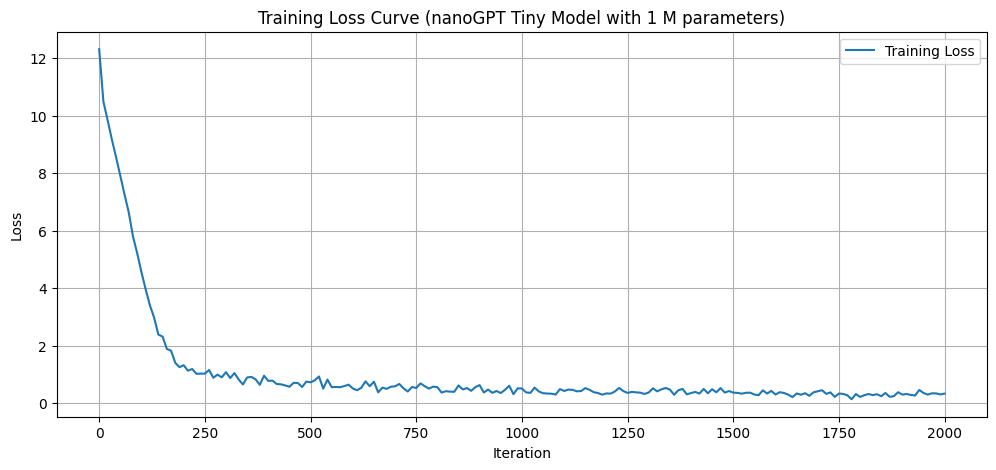

In [55]:
import re
import matplotlib.pyplot as plt

log_file = "/content/train_log.txt"

iters = []
losses = []

with open(log_file, "r") as f:
    for line in f:
        m = re.search(r"iter\s+(\d+): loss ([0-9.]+)", line)
        if m:
            iters.append(int(m.group(1)))
            losses.append(float(m.group(2)))

print(f"Parsed {len(iters)} points.")

plt.figure(figsize=(12, 5))
plt.plot(iters, losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve (nanoGPT Tiny Model with 1 M parameters)")
plt.grid(True)
plt.legend()
plt.show()


I trained the model using our nanoGPT based model, and am seeing a loss vs iteration curve.

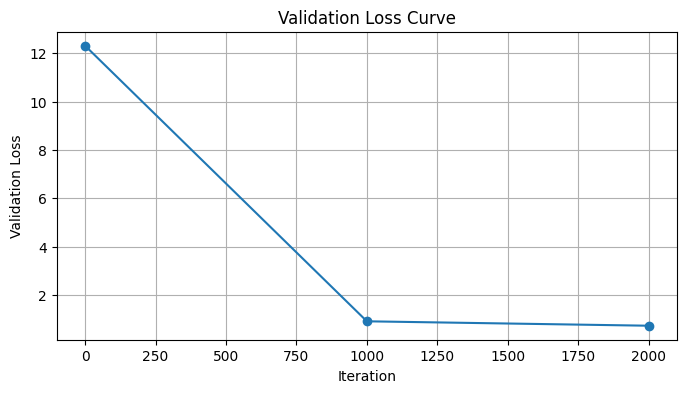

In [56]:
val_iters = []
val_losses = []

with open(log_file, "r") as f:
    for line in f:
        m = re.search(r"step\s+(\d+): train loss [0-9.]+, val loss ([0-9.]+)", line)
        if m:
            val_iters.append(int(m.group(1)))
            val_losses.append(float(m.group(2)))

plt.figure(figsize=(8,4))
plt.plot(val_iters, val_losses, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curve")
plt.grid(True)
plt.show()


In [67]:
import os

save_dir = "/content/tiny_model"
os.makedirs(save_dir, exist_ok=True)
print("Saving everything into:", save_dir)


Saving everything into: /content/tiny_model


In this I generated the validation vs loss curve which seems to be decreasing linearly until 1000 iterations.